# AML Assignment-2

| Name                | ID         |
|---------------------|------------|
| Ananya Sinha        | MDS202307  |
| Divyanshi Kumari    | MDS202322  |
| Rohit Roy           | MDS202340  |

# Question 3

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda:0


### Setting Parameters

In [4]:
# Data
train_data_path = './data/FashionMNIST/fashion-mnist_train.csv'
valid_data_path = './data/FashionMNIST/fashion-mnist_test.csv'

img_size = 28 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 30  # Train epochs
learning_rate = 1e-4

### Loading Data

In [5]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [6]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [7]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


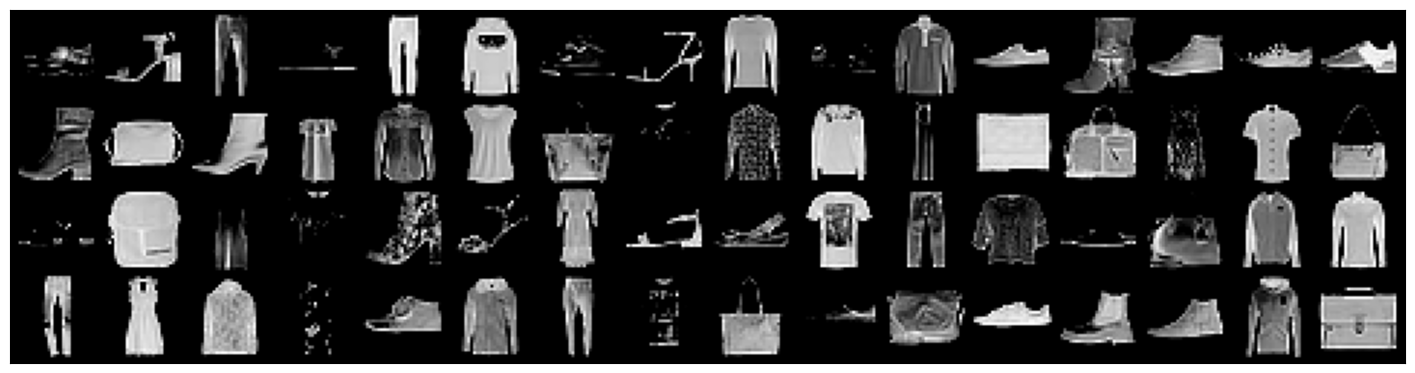

In [8]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

### Defining Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

### Defining Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [11]:
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

### Training Step

In [12]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [13]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [14]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

In [15]:
def plot_sample_images(images_per_class, subplot_size, font_size):
    # Building z 
    z = Variable(torch.randn(class_num*images_per_class, z_size)).to(device)

    # Labels 0 ~ 9
    labels = Variable(torch.LongTensor([i for _ in range(images_per_class) for i in range(class_num)])).to(device)

    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    # Show images
    grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
    fig, ax = plt.subplots(figsize=(subplot_size,subplot_size))
    ax.imshow(grid)
    _ = plt.yticks([])
    _ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=font_size)
    plt.show()

Epoch 1/30: 100%|██████████| 938/938 [00:26<00:00, 35.20batch/s, d_loss=0.245, g_loss=3.39] 


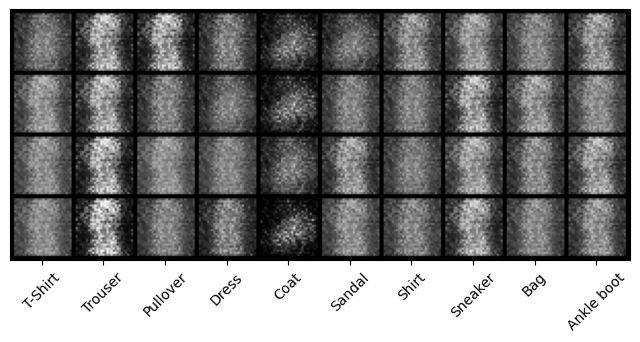

Epoch 6/30: 100%|██████████| 938/938 [00:26<00:00, 35.30batch/s, d_loss=0.414, g_loss=2.56]


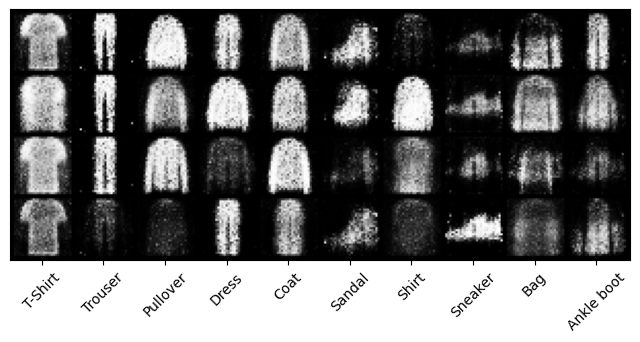

Epoch 11/30: 100%|██████████| 938/938 [00:26<00:00, 35.86batch/s, d_loss=1.01, g_loss=1.86] 


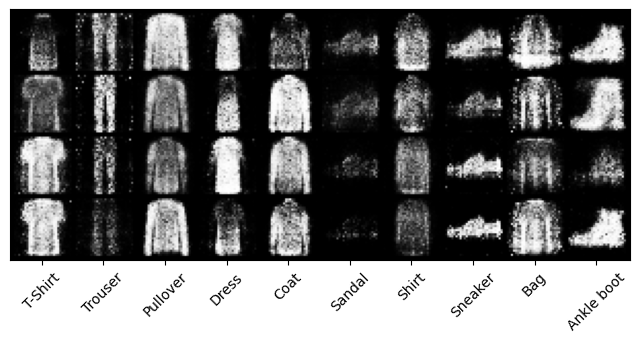

Epoch 16/30: 100%|██████████| 938/938 [00:26<00:00, 35.59batch/s, d_loss=0.756, g_loss=1.62]


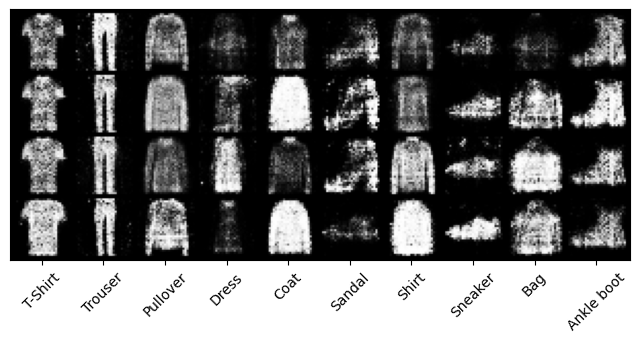

Epoch 21/30: 100%|██████████| 938/938 [00:25<00:00, 36.39batch/s, d_loss=1.02, g_loss=1.48]  


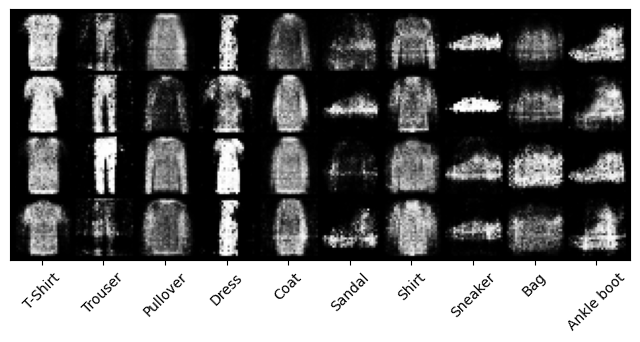

Epoch 26/30: 100%|██████████| 938/938 [00:26<00:00, 35.60batch/s, d_loss=1, g_loss=1.21]     


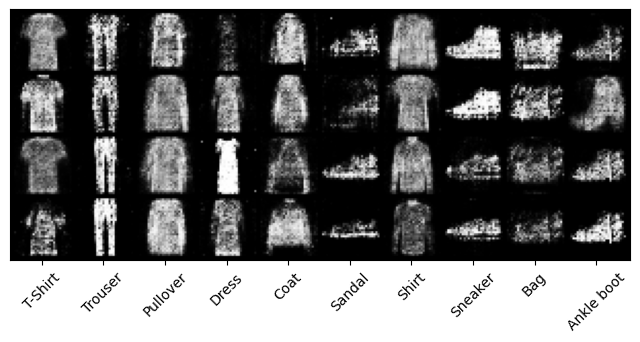

Epoch 30/30: 100%|██████████| 938/938 [00:25<00:00, 36.48batch/s, d_loss=0.997, g_loss=1.37] 


In [16]:
# Number of images per class to display
images_per_class = 4

# Training loop
for epoch in range(epochs):
    
    # Create tqdm progress bar for batches
    with tqdm(total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
        
        for i, (images, labels) in enumerate(data_loader):
            
            # Train data
            real_images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            
            # Set generator train
            generator.train()
            
            # Train discriminator
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
            
            # Train generator
            g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
            
            # Update tqdm progress bar
            pbar.set_postfix({'d_loss': d_loss.item(), 'g_loss': g_loss.item()})
            pbar.update(1)  # Update progress bar after every batch
        
    # After epoch, set generator to eval and generate sample images
    generator.eval()
    if epoch%5 == 0:
        plot_sample_images(images_per_class, 8, 10)

### Generating Images

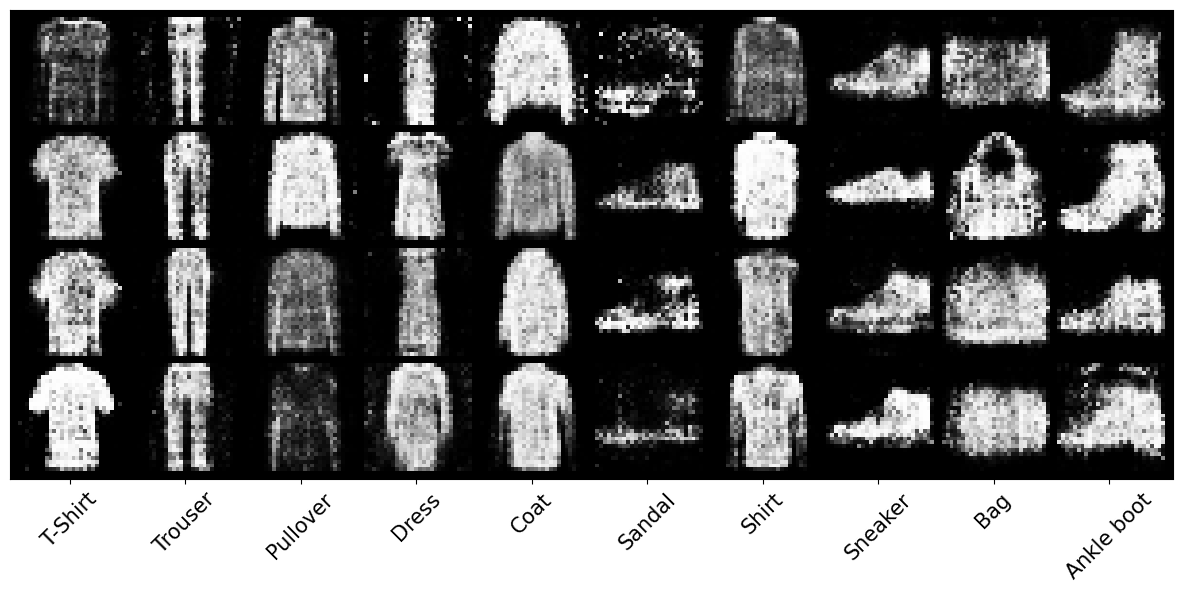

In [17]:
plot_sample_images(images_per_class, 15, 15)